In [1]:
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

In [2]:
from feed_forward_network import FeedForwardNetwork
from preprocessing import *
from utils import *
from features import *

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.)
else:
    device = torch.device("cpu")
device

device(type='mps')

In [4]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [5]:
seq_len = 0
scale_output=True
target_column = 'NO1_consumption'

In [6]:
features_to_add = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {
            "shift_max": 10,
            "column_to_shift": "NO1_temperature",
            "new_column_name": "temp"
        }
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    (
        add_hour_columns,
        {}
    ),
    (
        get_yesterday_target_mean,
        {'target': 'NO1_consumption'}
    )
]

In [8]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (scalerInputMethod, scalerOutputMethod), df_target = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add,
        seq_len=seq_len,
        scale_output=scale_output
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'temp_1_previous', 'temp_2_previous',
       'temp_3_previous', 'temp_4_previous', 'temp_5_previous',
       'temp_6_previous', 'temp_7_previous', 'temp_8_previous',
       'temp_9_previous', 'temp_10_previous', 'consum_24_previous', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'NO1_consumption_yesterday_mean'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [39]:
seq_len = len(raw_data) - len(X_train) - len(X_test) - len(X_val)

24

In [10]:
model = FeedForwardNetwork(input_size=X_train.shape[1])
model.to(device)

FeedForwardNetwork(
  (net): Sequential(
    (0): Linear(in_features=41, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [11]:
lr = 0.01
num_epochs=100

In [12]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [13]:
model, losses, val_loss, opt = fit(
    model, 
    train_set=(X_train, y_train),
    val_set=(X_val, y_val),
    opt=opt,
    loss_func=loss_func,
    num_epochs=num_epochs,
    device=device
)

Python(21606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


device: mps


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


In [14]:
path = f'models/FeedForwardNet-{str(datetime.now().date())}-loss-{str(losses[len(losses)-1])}'
torch.save(model.state_dict(), path)

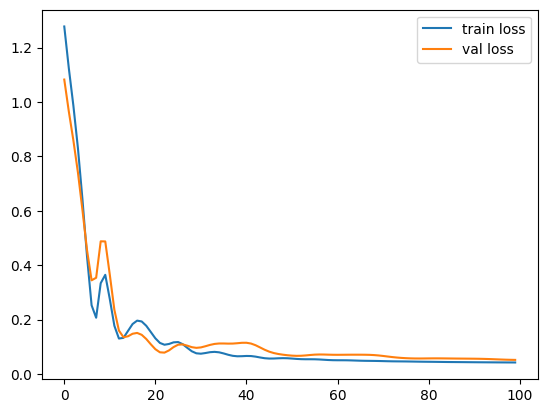

In [15]:
plt.plot(losses, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

In [16]:
y_test, y_pred = predict(model, scalerOutputMethod, (X_test, y_test))

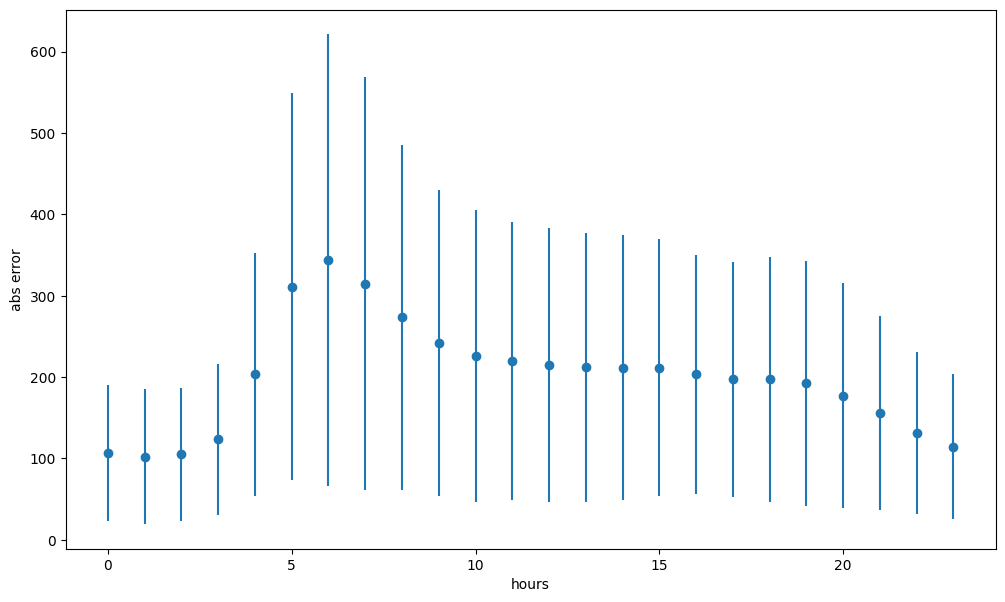

In [44]:
plot_error_by_hour_for_test_set(y_test, y_pred, start_hour=df_target['timestamp'].dt.hour.iloc[seq_len])

48


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


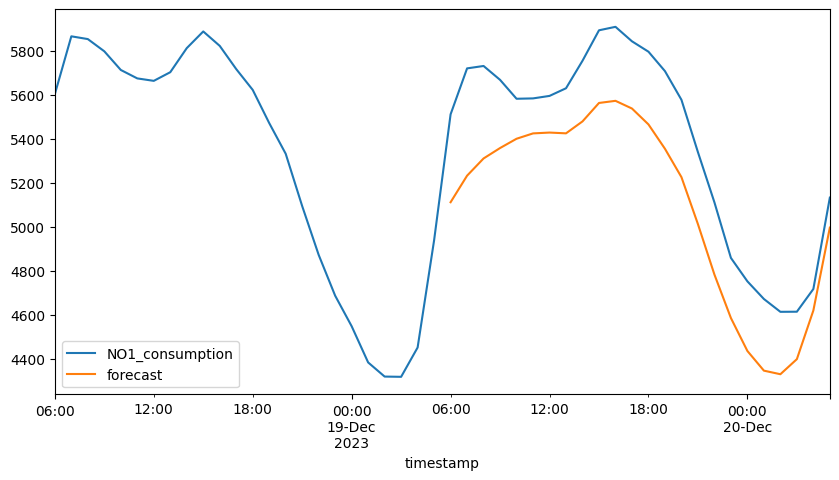

48


/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


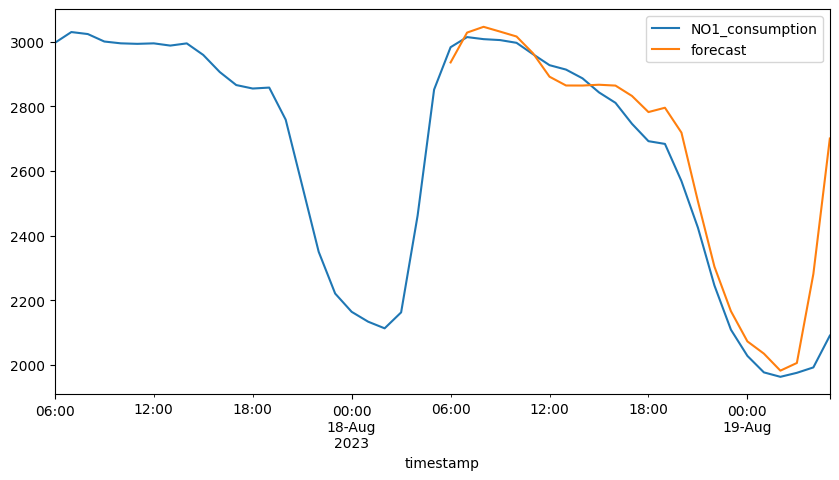

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


48


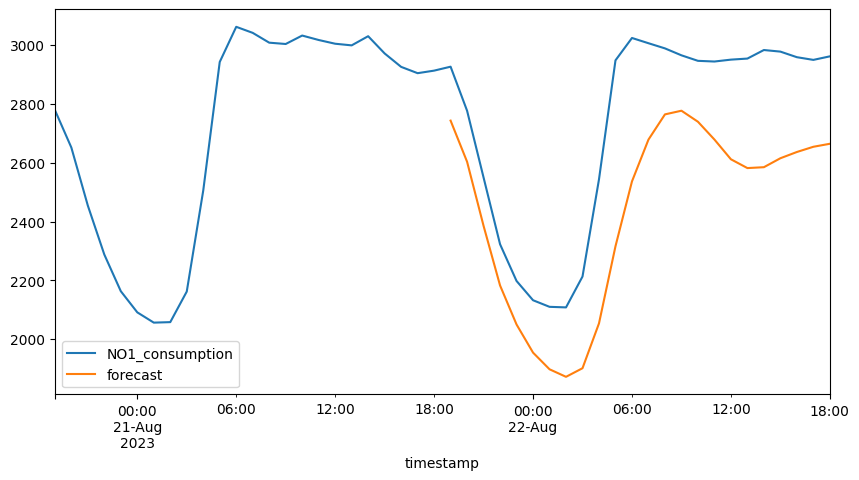

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


48


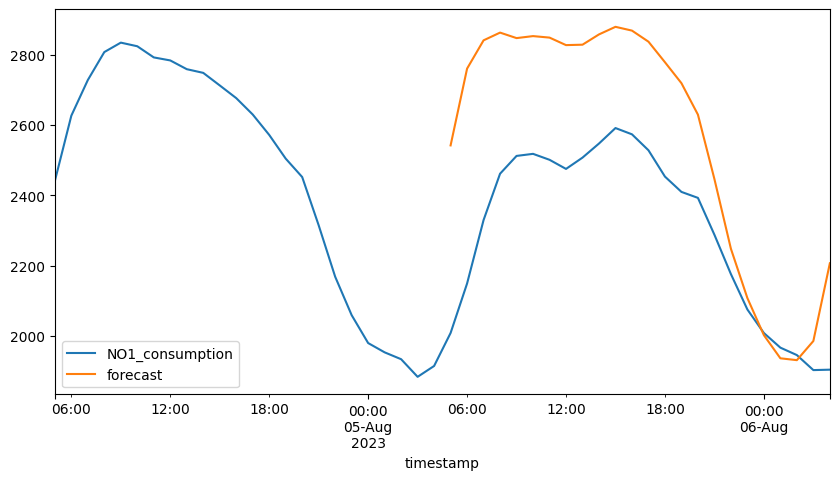

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


48


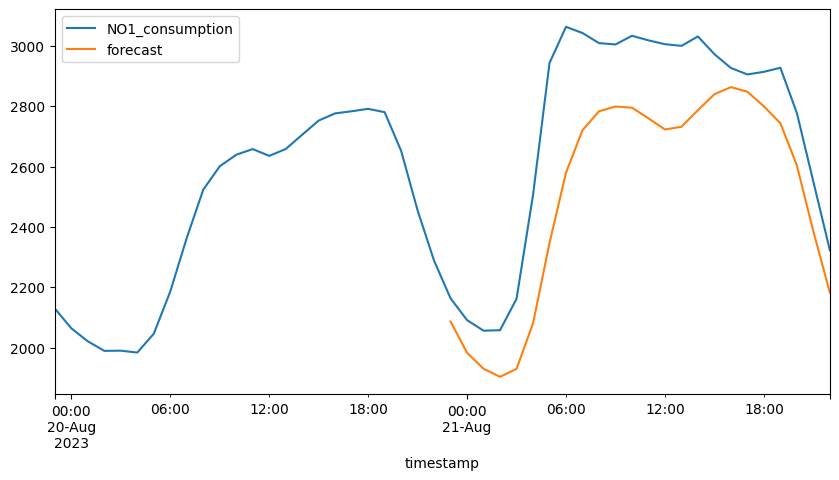

In [43]:
for k in range(5):
    make_forecast(y_pred=y_pred, df_target=df_target, seq_len=seq_len+1)

### Model of zone 1 applied on zone 2

In [19]:
features_to_add2 = [
    (   
        pick_location_data,
        { 'loc': [2] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {
            "shift_max": 10,
            "column_to_shift": "NO2_temperature",
            "new_column_name": "temp"
        }
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO2_consumption",
            "new_column_name": "consum"
        },
    ),
    (
        add_hour_columns,
        {}
    ),
    (
        get_yesterday_target_mean,
        {'target': 'NO2_consumption'}
    )
]

In [20]:
(X_train2, y_train2), (X_val2, y_val2), (X_test2, y_test2), (scalerInputMethod2, scalerOutputMethod2), df_target2 = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add2,
        seq_len=seq_len,
        scale_output=scale_output,
        target_column='NO2_consumption',
        features_to_scale=['NO2_temperature'],
    )

FEATURES:
 Index(['NO2_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'temp_1_previous', 'temp_2_previous',
       'temp_3_previous', 'temp_4_previous', 'temp_5_previous',
       'temp_6_previous', 'temp_7_previous', 'temp_8_previous',
       'temp_9_previous', 'temp_10_previous', 'consum_24_previous', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'NO2_consumption_yesterday_mean'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [21]:
_, y_pred12 = predict(model, scalerOutputMethod2, (X_test2, y_test2))


In [22]:
model2 = FeedForwardNetwork(input_size=X_train.shape[1])
model2.to(device)

loss_func2 = nn.MSELoss()
opt2 = optim.Adam(model2.parameters(), lr=lr)
model2, losses2, val_loss2, opt2 = fit(
    model2, 
    train_set=(X_train2, y_train2),
    val_set=(X_val2, y_val2),
    opt=opt2,
    loss_func=loss_func2,
    num_epochs=num_epochs,
    device=device
)

device: mps


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


In [23]:
y_test2, y_pred22 = predict(model2, scalerOutputMethod2, (X_test2, y_test2))

3 3
3 3


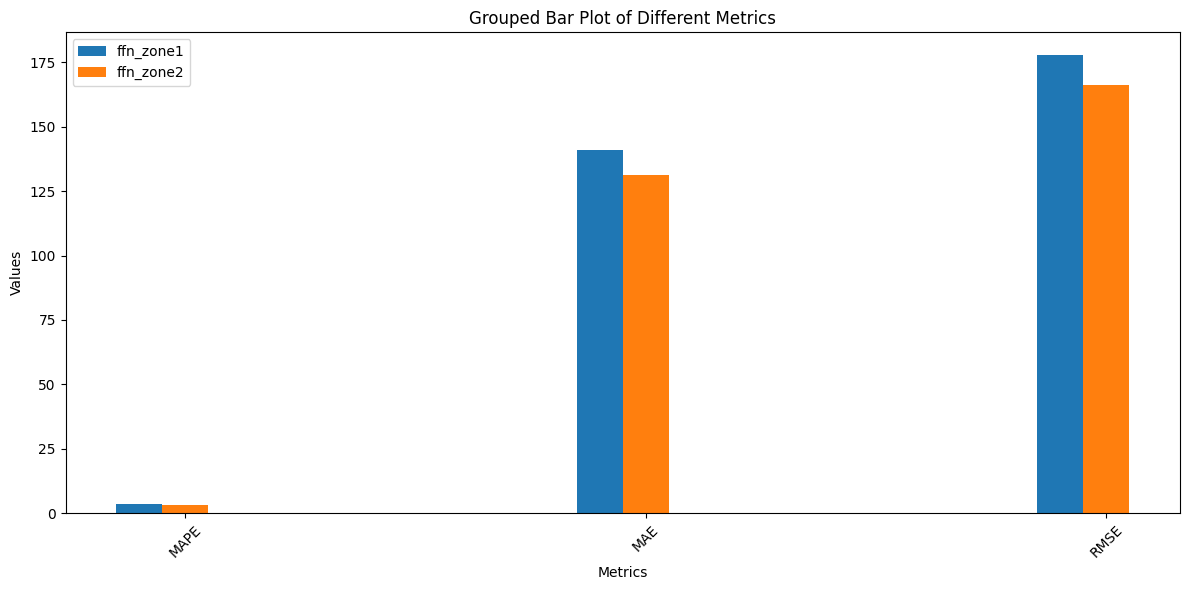

In [38]:
preds = {
    'ffn_zone1': torch.Tensor(y_pred12),
    'ffn_zone2': torch.Tensor(y_pred22),
}

targets = {
    'ffn_zone1': torch.Tensor(y_test2),
    'ffn_zone2': torch.Tensor(y_test2),
}
summary_bar_plot(preds=preds, targets=targets)